In [ ]:
import numpy as np
import os, wget, zipfile, shutil
import warnings, itertools, functools

from collections import OrderedDict
from argparse import ArgumentParser
from skimage import io as io, transform as tfm

import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rcParams["figure.figsize"] = (8, 4)
mpl.rcParams["axes.grid"     ] = False

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Conv2d as Conv, ConvTranspose2d as Deconv,  ReLU as Relu
from torch.nn import InstanceNorm2d as InstanceNorm, BatchNorm2d as BatchNorm
from torch.utils.tensorboard import SummaryWriter,  FileWriter,  RecordWriter
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

import torchvision
import torchvision.utils as utils
import torchvision.transforms as T
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, Callback, ModelCheckpoint

In [ ]:
from numba import jit, cuda 

In [ ]:
!pip install numba

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5955f6d928a5faafd609b79d6eebd9fc18c31ab1405ce4ca5ba9a1c61ae1c8ca
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 686kB 17.3MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 829kB 55.1MB/s 
     |████████████████████████████████| 645kB 50.9MB/s 
     |████████████████████████████████| 1.3MB 48.2MB/s 
     |████████████████████████████████| 143kB 61.1MB/s 
     |████████████████████████████████| 296kB 53.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=d0308adfb20bc65d5b7049cb0481691feb436e0b104addd2f4f5141e914142ab
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=8ab4073916043133dc52cd0885caf84d23ebe36523fc84438b937c402a6b43b2
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built future idna-ssl
  Found existing installation: future 0.16.0
    Uni

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F,  torch.optim as optim
import torchvision, torchvision.models as models, torchvision.transforms as T

import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt
import PIL.Image as Image, warnings; from IPython.display import clear_output

mpl.rcParams["figure.figsize"] = (14, 7); mpl.rcParams["axes.grid"] = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

Device in use: cuda


In [ ]:
class ImageLoader:

    def __init__(self, size: (int, tuple), resize: bool = True, interpolation = 2):

        """
        Args:

            size:
                Desired output size. If size is a sequence like (h, w), output size will
                be matched to this. If size is an int, smaller edge of the image will be
                matched to this number; i.e, if height > width, then image will be resca
                led to (size * height / width, size)

            resize:
                If True, PIL Image will be resized to the desired size

            interpolation:
                If resize set to True, this will be used inside torch.transforms.Resize()
        """

        transforms = []
        if resize: transforms.append(T.Resize(size = size, interpolation = interpolation))

        # compulsory to add this transformation to the list
        transforms.append(T.ToTensor()); self.transforms = T.Compose(transforms)


    def read_image(self, filepath: str) -> torch.tensor:

        """
        Return:
            Transformed torch tensor
        """

        image = Image.open(fp = filepath); image = self.transforms(image)
        image = image.to(device, torch.float)

        return image


    @staticmethod
    def show_image(tensor: torch.Tensor, title: str = "Image", save_: bool = False, filename: str = None):

        """
        Args:
            save_: If set to True, will save the image with filename "filename"
        """

        # Clone the tensor to CPU (to avoid any modifications to the original tensor)
        tensor = tensor.cpu().clone();

        # squeeze or unsqueeze the tensor to bring it to an appropiate shape
        if   len(tensor.shape) == 4: tensor = tensor.squeeze(0)
        elif len(tensor.shape) == 2: tensor = tensor.unsqueeze(0)
        elif len(tensor.shape) > 4 or len(tensor.shape) < 2:
            raise ValueError(f"Bad Input shape:: {tensor.shape}")

        # transform the tensor to PIL Image
        transforms = T.ToPILImage(); img = transforms(tensor)
        plt.imshow(img);  plt.title(title);  plt.pause(0.001)

        if save_: img.save(fp = filename)


In [ ]:
class MyModel(nn.Module):

    def __init__(self, con_layers: list = ['conv4_2'], sty_layers: list = None, mean: list = [0.485, 0.456, 0.406],
                 stdv: list = [0.229, 0.224, 0.225]):

        """
        Args:

            con_layers: Layers to be used for Content loss
            sty_layers: Layers to be used for Style loss

            mean: Mean to normalize the input tensor
            stdv: Stdv to normalize the input tensor
        """

        super().__init__(); # call the initializer of the super class

        mapping_dict =  {"conv1_1":  0, "conv1_2":  2,
                         "conv2_1":  5, "conv2_2":  7,
                         "conv3_1": 10, "conv3_2": 12, "conv3_3": 14, "conv3_4": 16,
                         "conv4_1": 19, "conv4_2": 21, "conv4_3": 23, "conv4_4": 25,
                         "conv5_1": 28, "conv5_2": 30, "conv5_3": 32, "conv5_4": 34}

        # convert the mean and stdv to torch.tensor
        mean = torch.tensor(mean, dtype = torch.float, device = device)
        stdv = torch.tensor(stdv, dtype = torch.float, device = device)
        self.transforms = T.Normalize(mean, stdv) # transform to normalize the image

        # create an integer mapping of the layer names
        # +1 to get the output of ReLu layer
        self.con_layers = [(mapping_dict[layer] + 1) for layer in con_layers];
        self.sty_layers = [(mapping_dict[layer] + 1) for layer in sty_layers];
        self.all_layers = self.con_layers + self.sty_layers

        # Initialize a pre-trained model in eval() mode since we don't want to update
        # the parameters of the VGG network
        self.vgg19 = models.vgg19(pretrained = True, progress = True).features
        self.vgg19 = self.vgg19.to(device).eval()

        # replace the max pooling layers by average pooling
        for name, layer in self.vgg19.named_children():
            if isinstance(layer, nn.MaxPool2d):
                self.vgg19[int(name)] = nn.AvgPool2d(kernel_size = 2, stride = 2)


    def forward(self, tensor: torch.Tensor) -> dict:

        sty_feat_maps = []; con_feat_maps = [];
        # normalize the input tensor and add the batch dimension
        tensor = self.transforms(tensor); x = tensor.unsqueeze(0)

        # collect the required feature maps
        for name, layer in self.vgg19.named_children():
            x = layer(x);
            if int(name) in self.con_layers: con_feat_maps.append(x)
            if int(name) in self.sty_layers: sty_feat_maps.append(x)

        # return a dictionary of content and style output
        return {"Con_features": con_feat_maps, "Sty_features": sty_feat_maps}


In [ ]:
class NeuralStyleTransfer:

    def __init__(self, con_image: torch.Tensor, sty_image: torch.Tensor, size = 512, con_layers: list = None,
                 sty_layers: list = None, con_loss_wt: float = 1., sty_loss_wt: float = 1., var_loss_wt = 1.):

        """
        Args:
            con_loss_wt: Weightage of the Content loss
            sty_loss_wt: Weightage of the Style loss
            var_loss_wt: Weightage of the Variational loss
        """

        self.con_loss_wt = con_loss_wt; self.sty_loss_wt = sty_loss_wt;
        self.var_loss_wt = var_loss_wt; self.size = size;

        # initialize the model
        self.model = MyModel(con_layers = con_layers, sty_layers = sty_layers)
        self.sty_target = self.model(sty_image)["Sty_features"]
        self.con_target = self.model(con_image)["Con_features"]

        # initialize the variable image with requires_grad_ set to True
        self.var_image = con_image.clone().requires_grad_(True).to(device)
        # self.var_image = torch.rand_like(con_image.clone(), device = device, requires_grad = True)


    @staticmethod
    def _get_var_loss(tensor: torch.Tensor) -> torch.Tensor:

        # method to compute the variational loss of the image
        loss = (torch.sum(torch.abs(tensor[:, :, :-1] - tensor[:, :, 1:])) +
                torch.sum(torch.abs(tensor[:, :-1, :] - tensor[:, 1:, :])) )

        return loss


    @staticmethod
    def _get_con_loss(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        return 0.5 * torch.sum(torch.pow(pred - target, 2))


    @staticmethod
    def _get_gram_matrix(tensor: torch.Tensor) -> torch.Tensor:

        """
        Returns: Normalized Gram Matrix of the input tensor
        """

        b, c, h, w  = tensor.size(); tensor_ = tensor.view(b * c, h * w);
        gram_matrix = torch.mm(tensor_, tensor_.t())

        return gram_matrix


    def _get_sty_loss(self, pred: torch.Tensor, target: torch.Tensor):

        Z = np.power(np.prod(pred.size()), 2, dtype = np.float64)
        pred = self._get_gram_matrix(pred)

        return 0.25 * torch.sum(torch.pow(pred - target, 2)).div(Z)


    def _get_tot_loss(self, output: torch.Tensor):

        """
        output: model's predictions

        """

        con_output = output["Con_features"]; nb_con_layers = len(con_output);
        sty_output = output["Sty_features"]; nb_sty_layers = len(sty_output);

        # calculate the content and style loss for each layer
        con_loss = [self._get_con_loss(con_output[idx], self.con_target[idx]) for idx in range(nb_con_layers)]
        sty_loss = [self._get_sty_loss(sty_output[idx], self.sty_target[idx]) for idx in range(nb_sty_layers)]

        # weigh the loss by the appropiate weighing hyper-parameters
        con_loss = torch.mean(torch.stack( con_loss)) * self.con_loss_wt
        sty_loss = torch.mean(torch.stack( sty_loss)) * self.sty_loss_wt
        var_loss = self._get_var_loss(self.var_image) * self.var_loss_wt

        return con_loss.to(device), sty_loss.to(device), var_loss.to(device)


    def _print_statistics(self, epoch: int, image: torch.Tensor, tot_loss: torch.Tensor, con_loss: torch.Tensor,
                          sty_loss: torch.Tensor, var_loss: torch.Tensor):

        loader = ImageLoader(size = self.size, resize = True); clear_output(wait = True)
        loader.show_image(image.data.clamp_(0, 1), title = "Output_Image")

        sty_loss = round(sty_loss.item(), 4); con_loss = round(con_loss.item(), 4)
        tot_loss = round(tot_loss.item(), 4); var_loss = round(var_loss.item(), 4)

        print(f"After epoch {epoch + 1}:: Tot_loss: {tot_loss}")
        print(f"Sty_loss: {sty_loss}, Con_loss: {con_loss}, Var_loss: {var_loss}")



    # Using Adam to solve the optimization problem
    @jit
    def fit(self, nb_epochs: int = 10, nb_iters: int = 1000, lr: float = 1e-2, eps: float = 1e-8,
            betas: tuple = (0.9, 0.999)) -> torch.Tensor:

        # detach the targets from the graph to stop the flow of grads through them
        self.sty_target = [self._get_gram_matrix(x).detach() for x in self.sty_target]
        self.con_target = [x.detach() for x in self.con_target]

        optimizer = optim.Adam([self.var_image], lr = lr, betas = betas, eps = eps)

        for epoch in range(nb_epochs):
            for iter_ in range(nb_iters):

                self.var_image.data.clamp_(0, 1); optimizer.zero_grad();
                output = self.model(self.var_image);

                con_loss, sty_loss, var_loss = self._get_tot_loss(output)
                tot_loss = con_loss + sty_loss + var_loss

                tot_loss.backward(); optimizer.step()

            self._print_statistics(epoch, image = self.var_image, tot_loss = tot_loss,
                        con_loss = con_loss, sty_loss = sty_loss, var_loss = var_loss)

        return self.var_image.data.clamp_(0, 1)

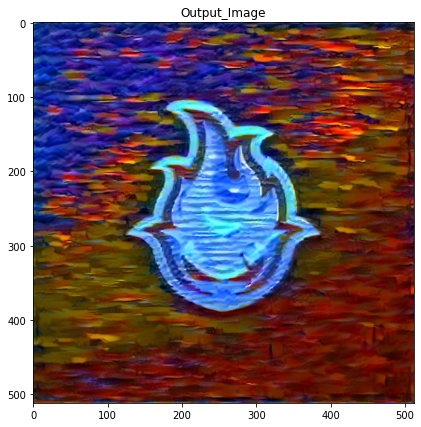

After epoch 5:: Tot_loss: 13.7364
Sty_loss: 7.3433, Con_loss: 3.8949, Var_loss: 2.4981


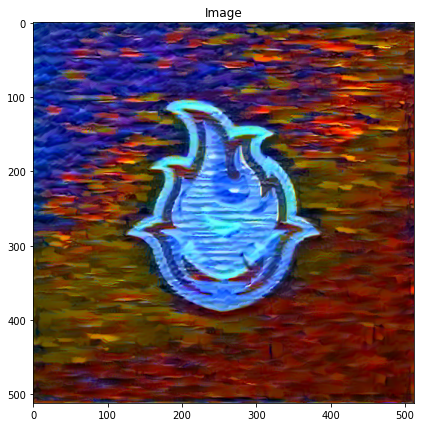

In [ ]:
con_img_fp = "filter_2.jpg"; sty_img_fp = "filter_7.jpg"
img_loader = ImageLoader(size = (512, 512), resize = True, interpolation = 2);

con_image = img_loader.read_image(filepath = con_img_fp)
sty_image = img_loader.read_image(filepath = sty_img_fp)

img_loader.show_image(con_image, title = "Content Image")
img_loader.show_image(sty_image, title = "Style Image")


con_layers = ["conv4_2"]; sty_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"];

_NST_ = NeuralStyleTransfer(con_image = con_image, sty_image = sty_image, size = (512, 512), con_layers = con_layers,
                            sty_layers = sty_layers, con_loss_wt = 1e-5, sty_loss_wt = 1e4, var_loss_wt = 5e-5)

output_image = _NST_.fit(nb_epochs = 10, nb_iters = 1000, lr = 1e-2, eps = 1e-8, betas = (0.9, 0.999))

img_loader = ImageLoader(size = 512, resize = True);
img_loader.show_image(output_image, save_ = True, filename = "Stylized_Image.jpg")
